# Exercise: Spectral Angle Maps

David R. Thompson, Jet Propulsion Laboratory, California Institute of Technology<br>
Contact: david.r.thompson@jpl.nasa.gov
__________

This exercise builds competance in manipulating spectroscopic data, and cultivates intuition interpreting spectra as high-dimensional vectors.  This time, you will want to actively modify this file with your own spectral mapping code! But first, import the python dependencies.  We load the target spectra from ASCII files as before.

In [42]:
import scipy as s
from scipy.linalg import norm
import pylab as plt
import figure_style

wavelengths = s.loadtxt('data/wavelengths.txt')
targets = s.loadtxt('data/targets.txt')

We load two specific reference spectra for further analysis.

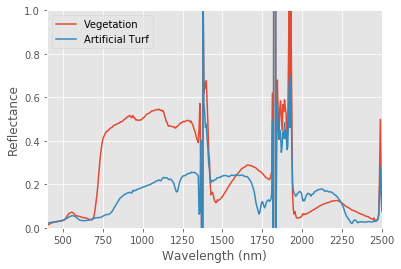

In [53]:
vegetation_reflectance = targets[:,2]
plt.plot(wavelengths, vegetation_reflectance)

artificial_turf_reflectance = targets[:,3]
plt.plot(wavelengths, artificial_turf_reflectance)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend(['Vegetation','Artificial Turf'])
plt.xlim([400,2500])
plt.ylim([0,1]);
plt.savefig('images/original.pdf')

Our calculations should exclude the "deep water vapor absorptions" near 1380 nm and 1880 nm.  We create an index array that selects only the good values from visible and shortwave infrared (SWIR) ranges.

In [54]:
vis_window = wavelengths<1280
swir_window_A = s.logical_and(wavelengths>1460, wavelengths<1750)
swir_window_B = wavelengths>2000
valid = s.logical_or(s.logical_or(vis_window, swir_window_A), swir_window_B)

The lesson described L2 normalization.  The exemplar spectra show its effect.

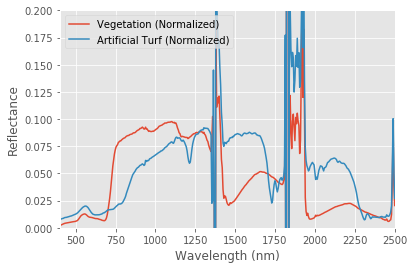

In [55]:
veg_L2_norm = s.sqrt(pow(vegetation_reflectance[use],2).sum())
plt.plot(wavelengths, vegetation_reflectance / veg_L2_norm)

turf_L2_norm = s.sqrt(pow(artificial_turf_reflectance[use],2).sum())
plt.plot(wavelengths, artificial_turf_reflectance / turf_L2_norm)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend(['Vegetation (Normalized)','Artificial Turf (Normalized)'])
plt.xlim([400,2500])
plt.ylim([0,0.2]);
plt.savefig('images/normalized.pdf')

Now, load the actual data cube into memory.  The file dimensions are stored in a detached human-readable ASCII file with the ".hdr" suffix, but here I've transcribed the key parts.  Note that it is single-precision floating point.  We use scipy's memory map object to reference the binary file. 

In [48]:

filename = '../01_Introduction/data/ang20171108t184227_corr_v2p13_subset_bil'
rows, bands, cols = 500,425,680
mm = s.memmap(filename, dtype=s.float32, mode='r',shape=(rows,bands,cols))

Spectroscopic data in cubes can be indexed in several ways; here the file is stored in Band-Interleaved-by-Line format.  This means that, when loaded, the cube indexing is in the order [row, channel, column].  We change this to a Band-Interleaved-by-Pixel format so that the order becomes [row, column, channel].  Since the memory map directly references a file, we must make a local copy of the whole thing in memory to do the transposition.  This is a little atypical; For the largest cubes, analysis will often proceed one row (or chunk of rows) at a time to save memory.  But this time, the cube is small enough that it should fit, and we can load it all at once. 

In [49]:
# Change to Band-In-Pixel interleave
X = s.asarray(mm,dtype = s.float32).copy().transpose((0,2,1))

We do not want the spectral angle map to be influenced by our deep water vapor absorption regions near 1400 and 1850 nm, since the reflectance in these areas is extremely noisy - the atmosphere is opaque in these regions meaning there's virtually no signal!  The  resulting extreme values  would dominate the spectral angle.  We could exclude those channels, or - as is done here - simply set them to zero.  We do the same for calibration errors in the longest wavelength channels.

In [50]:
# zero the deep water features and bad calibration in the extreme SWIR
deeph2o = s.logical_or(s.logical_and(wavelengths>1280, wavelengths<1450),
                       s.logical_and(wavelengths>1750, wavelengths<2000))
badcalibration = wavelengths>2480
bad = s.logical_or(deeph2o, badcalibration)
X[:,:,bad] = 0

Recall that the spectral angle equation is:
    $$SA(a,b) = \cos^{-1}\frac{a^Tb}{|a|_2 |b|_2}$$
Here's an example of spectral angle mapping for the first target spectrum in our list.  Don't forget to zero out the bad wavelength intervals!  There are more concise ways to do this with matrix operations rather than iterating through all rows and columns, but I wrote out the long form here for clarity.

In [51]:
# prepare the target spectrum
pool = targets[:,0]
pool[bad] = 0

# calculate spectral angle for all spectra
SA = s.zeros((rows,cols))
for r in range(rows):
    for c in range(cols):
        rfl = s.squeeze(X[r,c,:])
        angle = s.arccos(pool.dot(rfl)/(norm(pool)*norm(rfl)))
        SA[r,c] = angle

Let's see the result.  Low spectral angles correspond to good matches - in this case, the location of swimming pools!

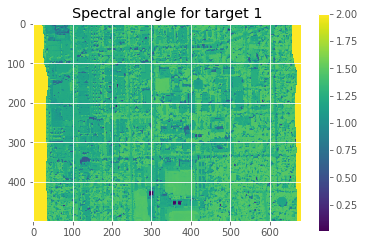

In [52]:
plt.imshow(SA)
plt.colorbar()
plt.title('Spectral angle for target 1')
plt.savefig('images/spectralangle1.png');

Finally, save the result as its own file as a binary cube.  We build an ASCII header for output using a similar (ENVI"-format) convention, so that your visualization software will understand how to load it.  Note that there is only one channel - a scalar value for the first target's spectral angle. Naturally, you can concatenate as many such results as you like to construct your own N-D cube.

In [7]:
filename = 'results/pool'
rows_out, cols_out, bands_out = 500,680,1
mm = s.memmap(filename, dtype=s.float32, mode='w+',shape=(rows_out,cols_out,bands_out))
mm[:,:,:] = SA.reshape(rows_out, cols_out, bands_out)

header_file = 'results/pool.hdr'
header_content = '''ENVI
description = {Spectral Angle Map}
samples = ''' + str(cols_out) + '''
lines   = ''' + str(rows_out) + '''
bands   = ''' + str(bands_out) + '''
header offset = 0
file type = ENVI Standard
data type = 4
interleave = bip
sensor type = Unknown
byte order = 0'''

with open(header_file,'w') as fout:
    fout.write(header_content)

After it is loaded in your visualization tool, play with the contrast to find a threshold that finds only the target materials with as few "false positives" as possible. 

<b> Question 1</b> What is a good threshold for each of the targets? 

<b> Question 2</b> What are the common confuser materials for each target, and why? 

<b> Question 3</b> Which targets are the most challenging to detect? Which are the easiest? Why?

<b> Extra Credit: </b> Which buildings in the area have a roof made of the same material as that of the South Mudd GPS building at the northeast corner of California and Wilson?

-------------
<b>Acknowledgements</b>: A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. We acknowledge the support of a PRISM AITT grant from the National Aeronautics and Space Administration (NASA) Earth Science Technology Office. We acknowledge the support of the JPL and Caltech Presidents’ and Directors’ Fund Program. We thank other supporting sponsors including the NASA Earth Science Division for the HyspIRI preparatory campaign, the AVIRIS-NG instrument and the data analysis program “Utilization of Airborne Visible/Infrared Imaging Spectrometer Next Generation Data from an Airborne Campaign in India” NNH16ZDA001N-AVRSNG, for its support of the algorithm development; the Jet Propulsion Laboratory Research and Technology Development Program; and the NASA Center Innovation Fund managed in conjunction with the Jet Propulsion Laboratory Office of the Chief Scientist and Technologist. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.